<a href="https://colab.research.google.com/github/vanadnarayane26/Text_to_SQL_Spider-/blob/main/VVN_Text_to_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
#Installing libraries
!pip install -q datasets
!pip install -q transformers
!pip install -q rouge_score
!pip install -q evaluate
!pip install transformers[torch]
!pip install seaborn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [3]:
import os
os.environ['CURL_CA_BUNDLE'] = '1'

In [4]:
!pip install scikit-learn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [5]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import pandas as pd
import nltk
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_metric, Dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
# nltk.download('punkt')

In [6]:
# import zipfile
# import shutil

# # 定义上传的ZIP文件名
# zip_file_name = "punkt.zip"

# # 解压ZIP文件
# with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
#     zip_ref.extractall("punkt_data")

# # 复制解压后的数据包到nltk_data目录
# shutil.copytree("punkt_data", "/path/to/nltk_data/tokenizers/punkt")

In [7]:
# !pip install git+https://github.com/huggingface/datasets.git
!pip install py-rouge

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [8]:
rouge_score = evaluate.load("rouge")

In [9]:
df = pd.read_json('train.json')

In [10]:
df.head()

,db_id,query_toks_no_value,question_toks,query_toks,question,sql,query
0,department_management,"[select, count, (, *, ), from, head, where, ag...","[部, 门, 中, 有, 多, 少, 人, 年, 龄, 大, 于, 5, 6, 岁, ？]","[select, count, (, *, ), from, head, where, ag...",部门中有多少人年龄大于56岁？,"{'orderBy': [], 'from': {'table_units': [['tab...",SELECT count(*) FROM head WHERE age > 56
1,department_management,"[select, name, ,, born_state, ,, age, from, he...","[列, 出, 按, 年, 龄, 排, 序, 的, 部, 门, 负, 责, 人, 的, 姓, ...","[select, name, ,, born_state, ,, age, from, he...",列出按年龄排序的部门负责人的姓名、出生地和年龄。,"{'orderBy': ['asc', [[0, [0, 10, False], None]...","SELECT name , born_state , age FROM head ORD..."
2,department_management,"[select, creation, ,, name, ,, budget_in_billi...","[列, 出, 每, 个, 部, 门, 的, 创, 建, 年, 份, 、, 名, 称, 和, ...","[select, creation, ,, name, ,, budget_in_billi...",列出每个部门的创建年份、名称和预算。,"{'orderBy': [], 'from': {'table_units': [['tab...","SELECT creation , name , budget_in_billions ..."
3,department_management,"[select, max, (, budget_in_billions, ), ,, min...","[部, 门, 的, 最, 高, 预, 算, 和, 最, 低, 预, 算, 是, 多, 少, ？]","[select, max, (, budget_in_billions, ), ,, min...",部门的最高预算和最低预算是多少？,"{'orderBy': [], 'from': {'table_units': [['tab...","SELECT max(budget_in_billions) , min(budget_i..."
4,department_management,"[select, avg, (, num_employees, ), from, depar...","[排, 名, 在, 1, 0, 到, 1, 5, 之, 间, 的, 部, 门, 的, 平, ...","[select, avg, (, num_employees, ), from, depar...",排名在10到15之间的部门的平均雇员人数是多少？,"{'orderBy': [], 'from': {'table_units': [['tab...",SELECT avg(num_employees) FROM department WHER...


/tmp/ipykernel_1518/2598441774.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(l)


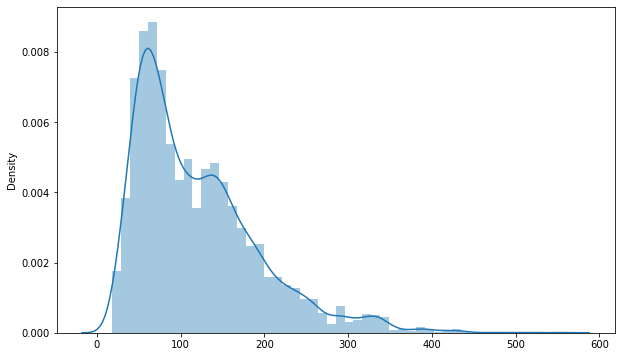

In [11]:
# Checking the sequence lengths for queries in dataset
l = []
for i in df['query']:
  l.append(len(i))

plt.figure(figsize = (10,6))
sns.distplot(l)
plt.show()

/tmp/ipykernel_1518/3711780259.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(l)


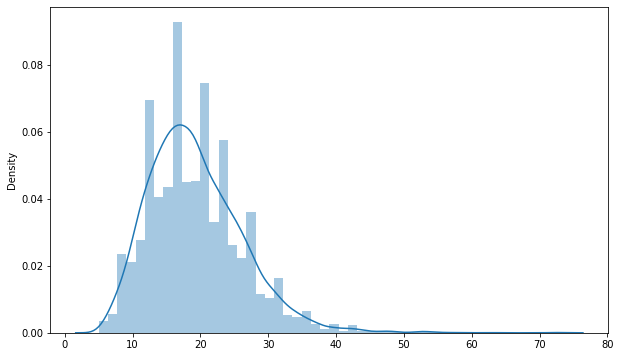

In [12]:
# Checking the sequence length for questions in the dataset
l = []
for i in df['question']:
  l.append(len(i))

plt.figure(figsize = (10,6))
sns.distplot(l)
plt.show()

In [13]:
df = df[['query','question']]

In [14]:
# Splitting the dataset into training and validation set
train_df, val_df = train_test_split(df,test_size = 0.1, random_state = 21)
print(train_df.shape)
print(val_df.shape)

(7793, 2)
(866, 2)


In [15]:
# Converting the pandas dataframe to huggingface datasets and drooping the index columns generated
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['query', 'question'],
    num_rows: 7793
})
Dataset({
    features: ['query', 'question'],
    num_rows: 866
})


In [16]:
train_dataset['query'][1]

'SELECT name FROM stadium WHERE id NOT IN (SELECT stadium_id FROM event)'

In [17]:
# downloading model from the checkpoint
from transformers import AutoTokenizer
model_checkpoint = "tscholak/2jrayxos"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
# Preprocessing and defining the sequence length for training the models
max_input_length = 256
max_target_length = 256


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples['question'],
        max_length=max_input_length,
        truncation=True, padding = 'max_length'
    )
    labels = tokenizer(text_target = examples['query'], max_length=max_target_length, truncation=True,padding = 'max_length')
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["labels_mask"] = labels["attention_mask"]
    return model_inputs

In [19]:
tokenized_train_datasets = train_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/7793 [00:00<?, ? examples/s]

In [20]:
tokenized_val_datasets = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/866 [00:00<?, ? examples/s]

In [21]:
tokenized_train_datasets = tokenized_train_datasets.remove_columns(['query','question'])
tokenized_val_datasets = tokenized_val_datasets.remove_columns(['query','question'])

In [22]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [23]:
data_collator = DataCollatorForSeq2Seq(model = model,tokenizer = tokenizer,label_pad_token_id=-100)

In [24]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [25]:
batch_size = 3
learning_rate = 1e-5
args = Seq2SeqTrainingArguments(
    "test-summary",
    evaluation_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=False,
    push_to_hub = False
)

In [26]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [27]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_val_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


In [ ]:
!huggingface-cli login

In [ ]:
!sudo apt-get install git-lfs

In [ ]:
!git lfs install

In [ ]:
!huggingface-cli repo create tscholak/2jrayxos-CSpider-mrking_v1

In [ ]:
model.save_pretrained('tscholak/2jrayxos-CSpider-mrking_v1',push_to_hub=True)
tokenizer.save_pretrained('tscholak/2jrayxos-CSpider-mrking_v1',push_to_hub=True)